In [1]:
# inspired from the work :
# https://www.kaggle.com/miguelniblock/predict-the-author-unsupervised-nlp-lsa-and-bow/data

In [67]:
# General-purpose Libraries
import numpy as np
import pandas as pd
import scipy
import sklearn
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import spacy
from time import time
%matplotlib inline

# Tools for processing data
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score
import nltk
# Classifiers, supervised and unsupervised
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AffinityPropagation
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from nltk.corpus import stopwords
stop_words = stopwords.words('english')

In [3]:
print (type(stop_words))
print (stop_words[:4])

<class 'list'>
['i', 'me', 'my', 'myself']


In [4]:
# Read data into a DataFrame
data = pd.read_csv('data/articles2.csv')
data.head()

,Unnamed: 0,id,title,publication,author,date,year,month,url,content
0,53293,73471,Patriots Day Is Best When It Digs Past the Her...,Atlantic,David Sims,2017-01-11,2017.0,1.0,NaN,"Patriots Day, Peter Berg’s new thriller that r..."
1,53294,73472,A Break in the Search for the Origin of Comple...,Atlantic,Ed Yong,2017-01-11,2017.0,1.0,NaN,"In Norse mythology, humans and our world were ..."
2,53295,73474,Obama’s Ingenious Mention of Atticus Finch,Atlantic,Spencer Kornhaber,2017-01-11,2017.0,1.0,NaN,“If our democracy is to work in this increasin...
3,53296,73475,"Donald Trump Meets, and Assails, the Press",Atlantic,David A. Graham,2017-01-11,2017.0,1.0,NaN,Updated on January 11 at 5:05 p. m. In his fir...
4,53297,73476,Trump: ’I Think’ Hacking Was Russian,Atlantic,Kaveh Waddell,2017-01-11,2017.0,1.0,NaN,Updated at 12:25 p. m. After months of equivoc...


In [5]:
print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49999 entries, 0 to 49998
Data columns (total 10 columns):
Unnamed: 0     49999 non-null int64
id             49999 non-null int64
title          49998 non-null object
publication    49999 non-null object
author         41401 non-null object
date           47373 non-null object
year           47373 non-null float64
month          47373 non-null float64
url            42988 non-null object
content        49999 non-null object
dtypes: float64(2), int64(2), object(6)
memory usage: 3.8+ MB
None


### 1. Basic Data Statistics :

- **49999** total entries in the dataset (articles2.csv)
- columns that are complete i.e. which do not have any missing data are : id, title, publication and content
- rest other columns have some missing values : author name, date of publication, url etc.

### Summary :
- **Content, title and publication** columsn are complete. These are the data points needed for further downstream tasks of clustering and classification.

### Length of Articles

- In terms of number of **words**, the average article has around **750 words**.

Statistical Summary of Article Lengths
count    49999.000000
mean       742.464149
std        898.129554
min          2.000000
25%        307.000000
50%        565.000000
75%        886.000000
max      29718.000000
dtype: float64


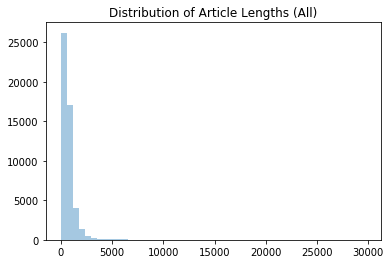

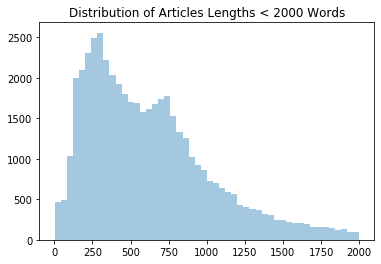

In [6]:
lengths = pd.Series([len(x.split(" ")) for x in data.content])
print('Statistical Summary of Article Lengths')
print(lengths.describe())

sns.distplot(lengths,kde=False)
plt.title('Distribution of Article Lengths (All)')
plt.show()
sns.distplot(lengths[lengths<2000],kde=False)
plt.title('Distribution of Articles Lengths < 2000 Words')
plt.show()

### 2. Publisher distribution:
- distribution based on publisher

- on an average a publisher published 7,142 articles

- we can see, New York Post is highest with 17493 articles (more than double the average), followed by Atlantic 7008 articles just near the average count and National Reviewwith 6203 articles, a little less than average.

- the publications thus can be said to be skewed with high contributions from New York Post.  


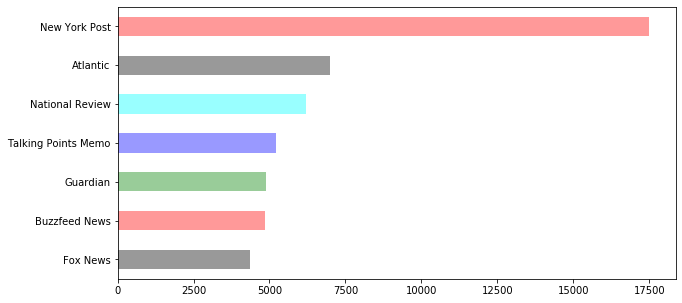

In [7]:
data.publication.value_counts().sort_values().plot(kind = 'barh', figsize=(10,5),alpha = 0.4, color=['black', 'red', 'green', 'blue', 'cyan'])

In [8]:
data.publication.value_counts()

New York Post          17493
Atlantic                7008
National Review         6203
Talking Points Memo     5214
Guardian                4873
Buzzfeed News           4854
Fox News                4354
Name: publication, dtype: int64

In [9]:
data.publication.value_counts().describe()

count        7.000000
mean      7142.714286
std       4653.248103
min       4354.000000
25%       4863.500000
50%       5214.000000
75%       6605.500000
max      17493.000000
Name: publication, dtype: float64

In [10]:
custom_stop_words = ["want", "updates", "receive", "continue", "writing", "great", "partners"]
stop_words += custom_stop_words
def remove_stop_words(text, stop_words):
    # Getting rid of the stopwords
    clean_text = [word for word in text.split() if word.lower() not in stop_words]

    # Converting the list to string
    text = ' '.join([str(elem) for elem in clean_text])
    return text

In [11]:
print ("It".lower() in stop_words)
print ("IT".lower() in stop_words)

True
True


### 2.1 Word Clouds :

- show most frequently occuring words, with higher frequency words corelating to high font size


['Atlantic' 'Fox News' 'Talking Points Memo' 'Buzzfeed News'
 'National Review' 'New York Post' 'Guardian']


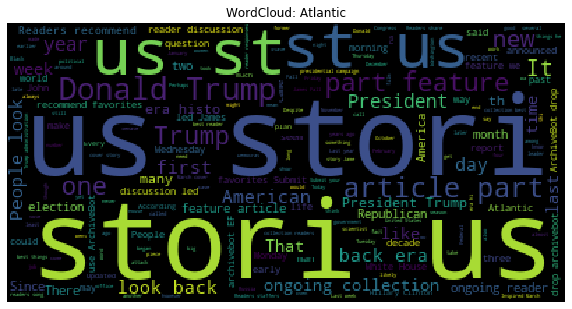

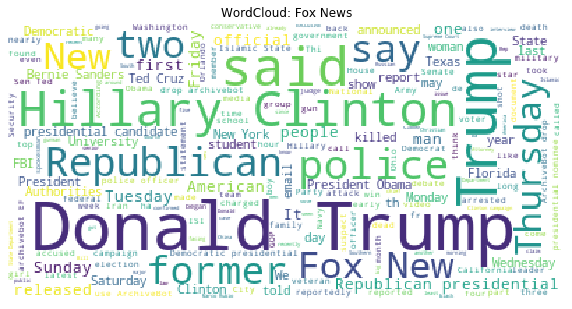

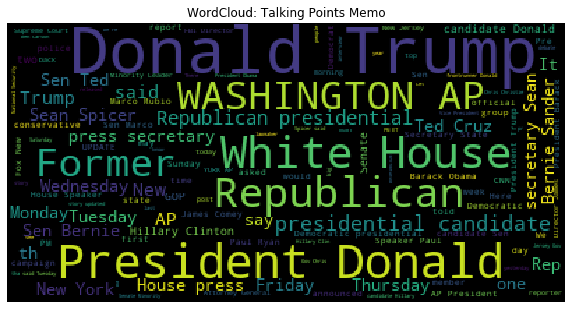

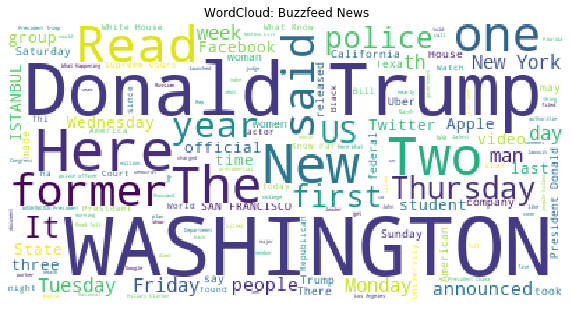

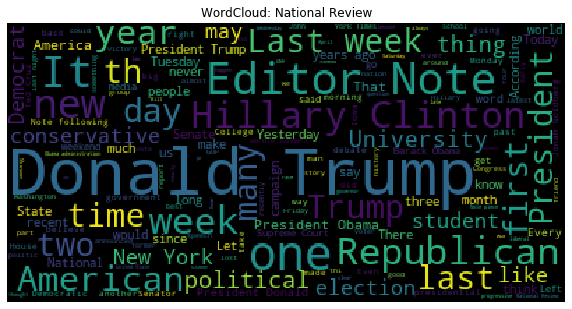

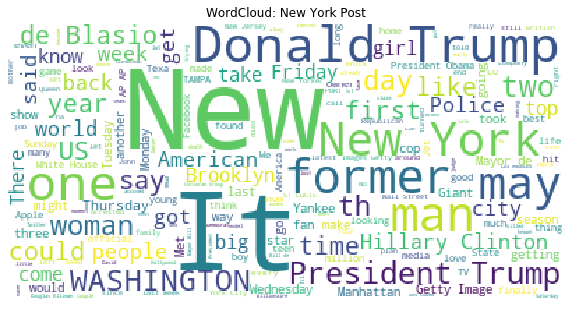

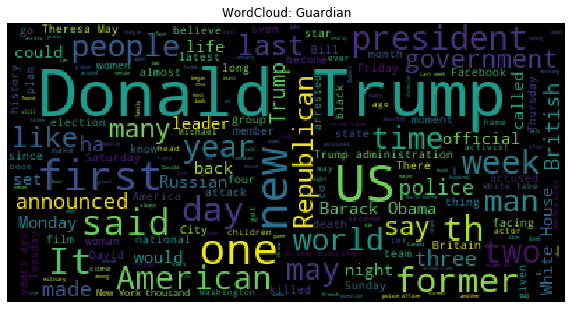

In [12]:
publishers = data['publication'].unique()
print (publishers)

plt.rcParams["figure.figsize"] = (10,8)

color_flag = True

for item in publishers:
    content = data.query('publication== @item')['content']
    content = content.to_string(index=False)
    # remove stop words
    content = remove_stop_words(content, stop_words)
    if color_flag:
        wordcloud = WordCloud(stopwords=stop_words).generate(content)
    else:
        wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(content)
    # Display the generated image:
    plt.title("WordCloud: " + item)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    color_flag = not color_flag

### 2.2 Scope the data for demonstration (downsampling) :
- for each of 7 publication sources 'Atlantic' 'Fox News' 'Talking Points Memo' 'Buzzfeed News'
 'National Review' 'New York Post' 'Guardian', we select first 100 articles published
 
- helps in avoiding the problem of **class imbalance** in the downstream classification tasks
 

In [47]:
# Make a DataFrame with limited number(500) for articles from each publisher
# Include publisher name, title and content

# DataFrame for articles of all chosen publishers
publication_data = pd.DataFrame()
for name in publishers:
    # Select each publisher's data
    articles = data[data.publication==name][:100][['title','content','publication']]
    # Append it to the DataFrame
    publication_data = publication_data.append(articles)

publication_data = publication_data.reset_index().drop('index',1)

# trim the content of each article to first 700 words
publication_data['content'].apply(lambda x: ' '.join(x.split()[:700]))
# publication_data['content_trimmed'] = publication_data['content'].str[:10]

publication_data.head()
# publication_data.tail()

,title,content,publication
0,Patriots Day Is Best When It Digs Past the Her...,"Patriots Day, Peter Berg’s new thriller that r...",Atlantic
1,A Break in the Search for the Origin of Comple...,"In Norse mythology, humans and our world were ...",Atlantic
2,Obama’s Ingenious Mention of Atticus Finch,“If our democracy is to work in this increasin...,Atlantic
3,"Donald Trump Meets, and Assails, the Press",Updated on January 11 at 5:05 p. m. In his fir...,Atlantic
4,Trump: ’I Think’ Hacking Was Russian,Updated at 12:25 p. m. After months of equivoc...,Atlantic


In [48]:
# Look for duplicates
print('Number of articles:',publication_data.shape[0])
print('Unique articles:',len(np.unique(publication_data.index)))

# Number of publishers
print('Unique publishers:',len(np.unique(publication_data.publication)))
print('')
print('Articles by publication:\n')

# Articles counts by author
print(publication_data.publication.value_counts())

Number of articles: 700
Unique articles: 700
Unique publishers: 7

Articles by publication:

Fox News               100
Guardian               100
New York Post          100
Talking Points Memo    100
National Review        100
Buzzfeed News          100
Atlantic               100
Name: publication, dtype: int64


### 3. Classifier : A text classifier
- a text classifier to predict the publication source for the given article content
- **target variable** = publication
- **predictor variable** = content

### 3.1 Supervised Feature Generation

Bag of words is a list of the most common words of a given source of text. To identify each author, I'll create a bag of words containing the most-common words of all authors combined. This set later becomes the basis for feature engineering.

### 3.2 Common Bag of Words
- Here I'll extract the most-common 1000 words from each author's corpus, store them in a list, and then eliminate duplicates.

In [49]:
t0 = time()

# Load spacy NLP object
nlp = spacy.load('en_core_web_sm')

# A list to store common words by all publishers
common_words = []

# A dictionary to store the spacy_doc object of each publisher
publication_docs = {}

for name in publishers:
    
    # Corpus is all the text written by that publisher
    corpus = ""
    # Grab all rows of current publisher, along the 'content' column
    publisher_content = publication_data.loc[publication_data.publication==name,'content']
    # Merge all articles in to the author's corpus
    for article in publisher_content:
        corpus = corpus + article
    # Let Spacy parse the author's body of text
    doc = nlp(corpus)
    
    # Store the doc in the dictionary
    publication_docs[name] = doc
        
    # Filter out punctuation and stop words.
    lemmas = [token.lemma_ for token in doc
                if not token.is_punct and not token.is_stop]
        
    # Return the most common words of that author's corpus.
    bow = [item[0] for item in Counter(lemmas).most_common(1000)]
    
    # Add them to the list of words by all authors.
    for word in bow:
        common_words.append(word)

# Eliminate duplicates
common_words = set(common_words)
    
print('Total number of common words:',len(common_words))
print("done in %0.3fs" % (time() - t0))

Total number of common words: 2490
done in 102.109s


In [51]:
# Let's see our 7 publishers in the dictionary
lengths = []
for k,v in publication_docs.items():
    print(k,'corpus contains',len(v),' words.')
    lengths.append(len(v))

Atlantic corpus contains 170591  words.
Fox News corpus contains 62917  words.
Talking Points Memo corpus contains 62214  words.
Buzzfeed News corpus contains 134946  words.
National Review corpus contains 110791  words.
New York Post corpus contains 53333  words.
Guardian corpus contains 102187  words.


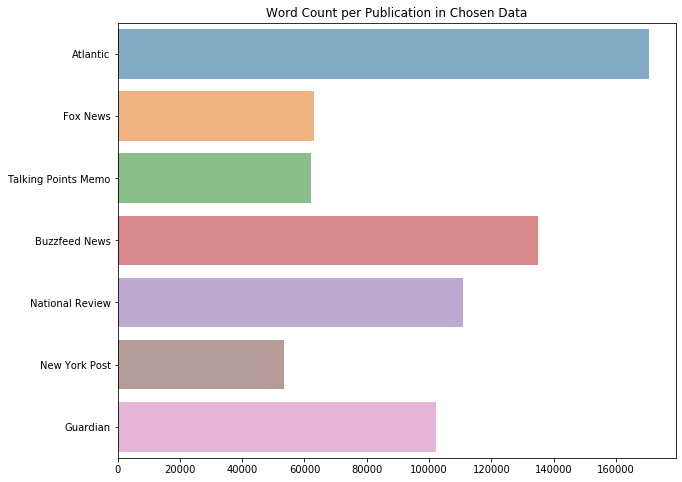

In [52]:
sns.barplot(x=lengths,y=publishers,orient='h', alpha = 0.6)
plt.title('Word Count per Publication in Chosen Data')
plt.show()

Atlantic corpus contains 170591  words.


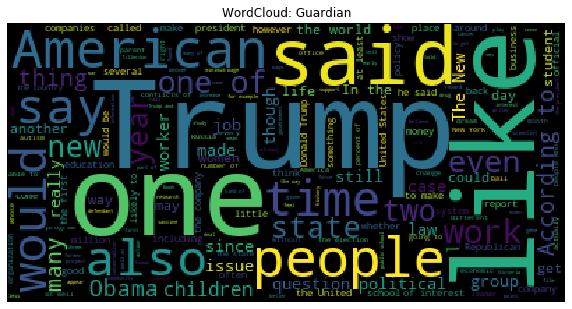

Fox News corpus contains 62917  words.


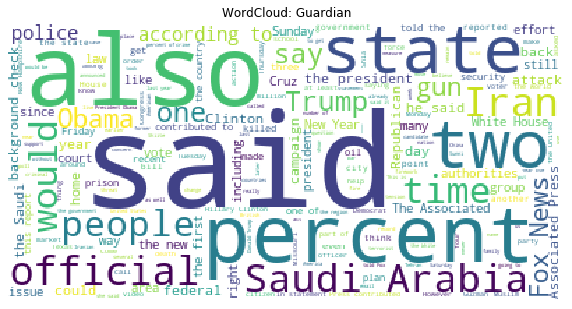

Talking Points Memo corpus contains 62214  words.


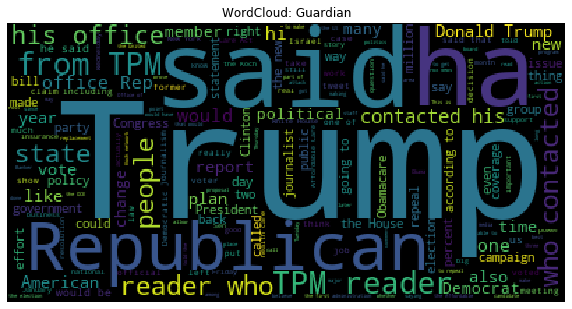

Buzzfeed News corpus contains 134946  words.


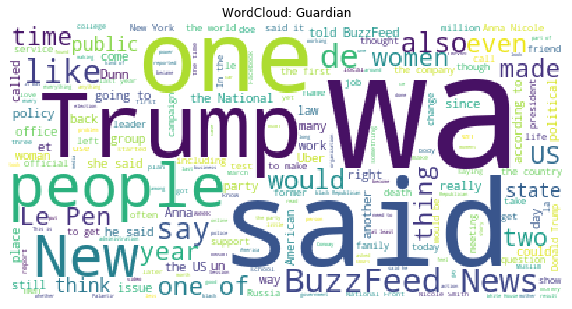

National Review corpus contains 110791  words.


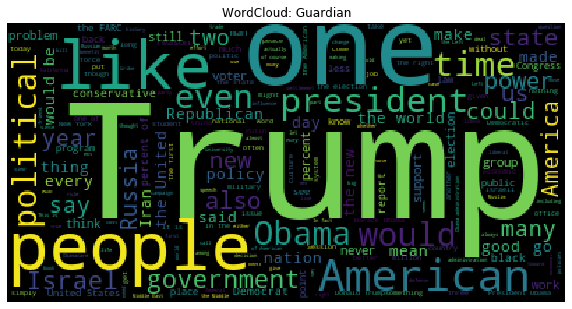

New York Post corpus contains 53333  words.


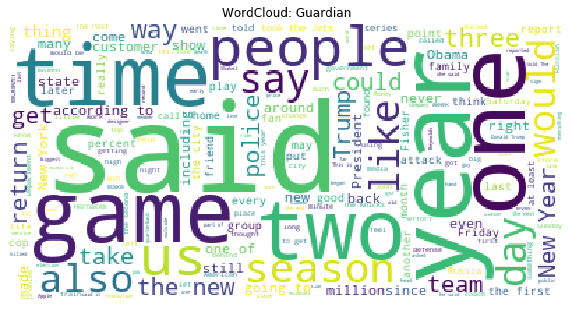

Guardian corpus contains 102187  words.


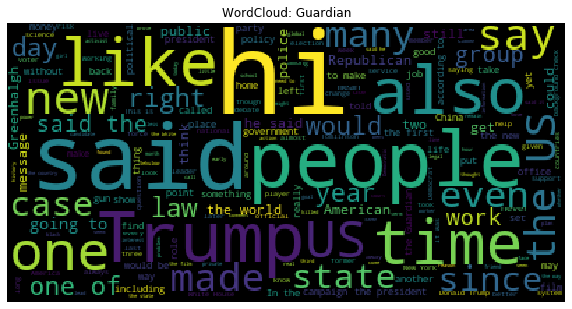

In [54]:
# word clouds for each publisher for the downsampled data
color_flag = True
for k,v in publication_docs.items():
    print(k,'corpus contains',len(v),' words.')
    content = str(v)
    if color_flag:
        wordcloud = WordCloud(stopwords=stop_words).generate(content)
    else:
        wordcloud = WordCloud(stopwords=stop_words, background_color="white").generate(content)
    # Display the generated image:
    plt.title("WordCloud: " + item)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()
    color_flag = not color_flag

### 3.3 CBOW to features :
- turning the common words into features

In [55]:
# check for lower case words
common_words = pd.Series(pd.DataFrame(columns=common_words).columns)
print('Count of all common_words:',len(common_words))
print('Count of lowercase common_words:',np.sum([word.islower() for word in common_words]))

# Turn all common_words into lower case
common_words = [word.lower() for word in common_words]
print('Count of lowercase common_words (After Conversion):',np.sum([word.islower() for word in common_words]))

Count of all common_words: 2490
Count of lowercase common_words: 1748
Count of lowercase common_words (After Conversion): 2420


In [57]:
# We must remove these in to avoid conflicts with existing features.
if 'author' in common_words:
    common_words.remove('author')
if 'title' in common_words:
    common_words.remove('title')
if 'content' in common_words:
    common_words.remove('content')

In [64]:
# a custom tokenize function to take care of single sentence as well as multiple sentence inputs
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation) 
    # and words whose length is less than 2 characters - removes 's, $ '  tokens from data 
    for token in tokens:
        if re.search('[a-zA-Z]', token) and len(token) > 2:
            filtered_tokens.append(token)
    return filtered_tokens


# tf-idf vectorizer:
publisher = publication_data["publication"].tolist()
content = publication_data["content"].tolist()

# initializing a tfIDF vectorizer for job_title corpus    
tfidf_vectorizer = TfidfVectorizer(max_df=0.7 , max_features=2000,
                                 min_df=2 , stop_words= stop_words,
                                 use_idf=False, tokenizer=tokenize_only)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(content) #fit the vectorizer to synopses


CPU times: user 5.48 s, sys: 0 ns, total: 5.48 s
Wall time: 5.48 s


In [70]:
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

dist = 1 - cosine_similarity(tfidf_matrix)

# TFIDF features on the entire corpus
# print (terms)
print ("number of features: ", len(terms))

(700, 2000)
number of features:  2000


In [71]:
# train test difference
print ("length of total publisher list:", len(publisher))
print ("length of total content list:", len(content))


length of total publisher list: 700
length of total content list: 700


### 3.4 Train - Test split :
- split the dataset in train-test via 80:20 ratio
- train = first 650 entries, test = last 50 entries

In [78]:
# function that takes (N*N) distance matrix for article content and returns the closest matching publication

def find_similar_content(dist, article_id):
    sorted_distances = dist[article_id].argsort() # sorting the distances
    similar_content = []
    for i in range(1, 8): # ignore element at zero index as it's the article itself.
        similar_content.append(content[sorted_distances[i]])
    for i in range(1, len(sorted_distances)): # iterate over similar publishers and return the one index is in train data (id < 650)
        if sorted_distances[i] < 650:
            return sorted_distances[i]
    return None

# function to predict target variable
def predict_publisher(article_id, distance_matrix):

    # find_similar_content() returns the id of most similar article content
    similar_content = find_similar_content(distance_matrix, article_id)
    return publisher[similar_content]
    

# sanity check
find_similar_content(dist, 200)
print (publisher[find_similar_content(dist, 200)])

Talking Points Memo


In [76]:
for i in range(650, 700):
    print (publisher[find_similar_content(dist, i)])

Atlantic
New York Post
Talking Points Memo
Atlantic
Talking Points Memo
Buzzfeed News
Buzzfeed News
National Review
Guardian
Fox News
Atlantic
Guardian
Guardian
Talking Points Memo
Talking Points Memo
Buzzfeed News
Atlantic
Buzzfeed News
Atlantic
Buzzfeed News
Buzzfeed News
Atlantic
National Review
Guardian
Guardian
Fox News
Atlantic
Atlantic
Buzzfeed News
Talking Points Memo
Guardian
Guardian
Fox News
Atlantic
Atlantic
Atlantic
Talking Points Memo
Atlantic
Buzzfeed News
Talking Points Memo
Atlantic
Atlantic
Guardian
New York Post
Guardian
Atlantic
Guardian
Atlantic
Atlantic
Atlantic


In [79]:
# pd.set_option('display.max_colwidth', 150)

df_tfIDF = publication_data
for i in range(650, 700):
    df_tfIDF["publication"][i] =  predict_publisher(i, dist)

# exporting the dataframe to json
out = df_tfIDF.to_json(orient='records')
# writing it to a file
with open('tfIDF.json', 'w') as f: 
    f.write(out)

df_tfIDF.tail(10)

,title,content,publication
680,Kong: Skull Island review – only de-evolution ...,Deep in the distant jungle … the undergr...,Guardian
681,How can we execute people if 1 in 25 on death ...,Arkansas executed Ledell Lee on Thursday night...,Guardian
682,Republicans must not tolerate the violence of ...,Republican Greg Gianforte won a special congre...,Fox News
683,TVs spying on us is just the tip of the iceber...,"As the FBI director, James Comey, recently sai...",Atlantic
684,Clive James: ‘Even the most trite Netflix dram...,A generous friend has given me a Netflix subsc...,Atlantic
685,Police say they were ’authorized by McDonald’s...,Police claimed they had “authorization from th...,Atlantic
686,The Republicans who are not totally enthusiast...,"If you’re a congressional Republican, you cons...",Talking Points Memo
687,Anti-surveillance clothing aims to hide wearer...,The use of facial recognition software for com...,Atlantic
688,The Resistance Now: Sign up for weekly news up...,"From the women’s marches, to airport protests,...",Buzzfeed News
689,Get Me Roger Stone review – grim if gripping p...,Fortuitously timed doesn’t begin to describe t...,Talking Points Memo


In [84]:
gt_data = publisher[:50]
len(gt_data)

tfIDF_predicted_data = [ predict_publisher(i, dist) for i in range(650,700)]

y_actu = pd.Series(gt_data, name='Actual')
y_pred = pd.Series(tfIDF_predicted_data, name='tfIDF_Predicted')
df_confusion_tfIDF = pd.crosstab(y_actu, y_pred)
df_confusion_tfIDF

tfIDF_Predicted,Atlantic,Buzzfeed News,Fox News,Guardian,National Review,New York Post,Talking Points Memo
Actual,,,,,,,
Atlantic,18,8,3,10,2,2,7


In [86]:
# def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
#     plt.matshow(df_confusion, cmap=cmap) # imshow
#     #plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(df_confusion.columns))
#     plt.xticks(tick_marks, df_confusion.columns, rotation=45)
#     plt.yticks(tick_marks, df_confusion.index)
#     #plt.tight_layout()
#     plt.ylabel(df_confusion.index.name)
#     plt.xlabel(df_confusion.columns.name)

# plot_confusion_matrix(df_confusion_tfIDF)
# # plot_confusion_matrix(df_confusion_wmd)